In [1]:
import pandas as pd
import re
import string
import nltk
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
tweet_df = pd.read_csv("ExtractedTweets.csv")
tweet_df.head()


,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


## Mapping tweets to political party
Above Dataframe contains tweets by republican and democratic congress members. I wanted to know if we can look at the tweets themselves, and determine if the member who created the tweet was a democrat or a republican. Some of the tweets are retweets. I am going to operate under the assumption that retweets are likely to still represent values that relate to the party.  This may be a poor assumption, and we likely should just analyze non retweets or attempt to determine the differences between the sets, but as this is an introductory attempt to use NLP to determine party preference, we will assume retweets by a representative are likely to represent their party ideology.  

## Feature Engineering 
+ As these are tweets, # and @ will likely carry importance
+ My idea is to extract all of these from the tweet column and build them out as features via the countvectorizer/tdIDF vectorizer
    + Retweets mentioning the candidates name may unfairly bias the data.  I will attempt to run models with these values present and models with them extracted. Hopefully feature importance can identify 
+ Certain policy terms should surely give away ideology.  I.E terms like "pro-life" or "pro-gun", " pro choice"
    + I will build out features to vectorize these likely hot topic issues
+ In the end I will use 

## Functions


In [22]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
tweet_df = pd.read_csv("ExtractedTweets.csv")


def initial_casechange(text):
    text = "".join([word.lower()
                    for word in text if word not in string.punctuation])


def clean_text(text):
    text = "".join([word.lower()
                    for word in text if word not in string.punctuation])
    text=re.sub(r'[0-9]+', '', text)
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text


def Remove_Twitter_Tags(tweet_df):
    tweet_df['No_Twitter_Tags'] = tweet_df['Tweet'].apply(
        lambda x:  re.sub(r"(@\w+)", " ", x))
    tweet_df['No_Twitter_Tags'] = tweet_df['No_Twitter_Tags'].apply(
        lambda x:  re.sub(r"(#\w+)", "", x))
    tweet_df['No_Twitter_Tags'] = tweet_df['No_Twitter_Tags'].apply(
        lambda x:  re.sub(r'https?://t.co/(?:[-\w.]|(?:%[\da-fA-F]{2}))+', "", x))
    return tweet_df

def map_retweets(tweet_df):
    mapped_retweets= []
    for x in tweet_df["Retweet"]:
        if len(x)==0:
            mapped_retweets.append(0)
        elif len(x)==1:
            mapped_retweets.append(1)
        elif len(x)==2:
            mapped_retweets.append(2)
        elif len(x)==3:
            mapped_retweets.append(3)
    tweet_df["Retweet"]= pd.Series(mapped_retweets)
    return tweet_df


def Find_Twitter_Tags(tweet_df):
    tweet_df["Retweet"] = tweet_df['Tweet'].apply(
        lambda x:  re.findall(r"(RT )", x))
    tweet_df['Handles'] = tweet_df['Tweet'].apply(
        lambda x:  re.findall(r"(@\w+)", x))
    tweet_df['HashTags'] = tweet_df['Tweet'].apply(
        lambda x:  re.findall(r"(#\w+)", x))
    tweet_df['links'] = tweet_df['Tweet'].apply(lambda x:  re.findall(
        'https?://t.co/(?:[-\w.]|(?:%[\da-fA-F]{2}))+', x))
    tweet_df['Total_characters'] = tweet_df['Tweet'].apply(lambda x: len(x))
    tweet_df= map_retweets(tweet_df)
    tweet_df = Remove_Twitter_Tags(tweet_df)
    tweet_df['No_Twitter_Tags']  = tweet_df['No_Twitter_Tags'].apply(
        lambda x:  re.sub(r"RT ", ' ', x))
    tweet_df['Avg_word_length'] = tweet_df['No_Twitter_Tags'].apply(lambda x: np.mean([len(w) for  w in x.split()]))
    return(tweet_df)

def make_bigrams(text):
    text = "".join([word.lower()
                    for word in text if word not in string.punctuation])
    text=re.sub(r'[0-9]+', '', text)
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    ngrams = zip(*[text[i:] for i in range(2)])
    text= [" ".join(ngram) for ngram in ngrams]
    return text

def stemmer(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

## Build DF

In [23]:
tweet_df =Find_Twitter_Tags(tweet_df)
tweet_df["Retweet"].value_counts()
tweet_df.head()

,Party,Handle,Tweet,Retweet,Handles,HashTags,links,Total_characters,No_Twitter_Tags,Avg_word_length
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",0,[],"[#SaveTheInternet, #NetNeutrality]",[https://t.co/n3tggDLU1L],139,"Today, Senate Dems vote to . Proud to support ...",4.666667
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,1,"[@WinterHavenSun, @RepDarrenSoto]",[],[],140,: Winter Haven resident / Alta Vista teacher...,5.000000
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,1,"[@NBCLatino, @RepDarrenSoto]",[],[],140,: . noted that Hurricane Maria has left app...,5.222222
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,1,"[@NALCABPolicy, @RepDarrenSoto, @LatinoLeader]",[#NALCABPolicy2018],[],140,: Meeting with . Thanks for taking the tim...,3.937500
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,1,"[@Vegalteno, @Pwr4PuertoRico, @RepDarrenSoto, ...",[],[],133,: Hurricane season starts on June 1st; Puert...,6.090909


## EDA of party representation

In [24]:

tweet_df.groupby('Party').mean()  


,Retweet,Total_characters,Avg_word_length
Party,,,
Democrat,0.216269,131.289698,4.823613
Republican,0.225469,128.681654,4.831475


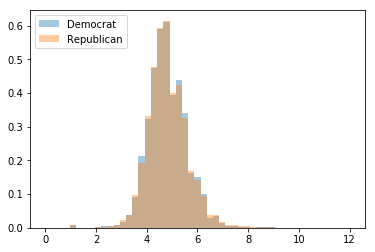

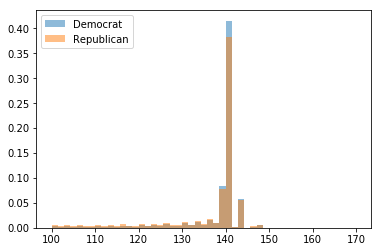

In [25]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline


bins = np.linspace(0, 12)
pyplot.hist(tweet_df[tweet_df['Party']=='Democrat']['Avg_word_length'], bins, alpha=0.4, normed=True, label='Democrat')
pyplot.hist(tweet_df[tweet_df['Party']=='Republican']['Avg_word_length'], bins, alpha=0.4, normed=True, label='Republican')
pyplot.legend(loc='upper left')
pyplot.show()


bins = np.linspace(100, 170)
pyplot.hist(tweet_df[tweet_df['Party']=='Democrat']['Total_characters'], bins, alpha=0.5, normed=True, label='Democrat')
pyplot.hist(tweet_df[tweet_df['Party']=='Republican']['Total_characters'], bins, alpha=0.5, normed=True, label='Republican')
pyplot.legend(loc='upper left')
pyplot.show()

Given the above Histograms, these features don't seem like they will help much 

## Example of bigrams we expect to have strong influence
+ If I had more time, I would develop custom built bigrams
+ politically charged language is likely to represent ideology
+ Below we serach for all combinations  of the word Pro-life and dispaly which party rep used the langauge and how often


In [26]:
tweet_df['Pro_life'] =tweet_df['Tweet'].apply(lambda x: re.findall(r"([pP]ro(?:-|\s)[Ll]ife)",x))
indexes = [i for i,x in enumerate(tweet_df['Pro_life']) if  x]
tweet_df['Party'][indexes]

print("Out of {} uses of the word pro life, {} are Democrats, {} are Republicans".format(len(indexes),
                                                       len(tweet_df.iloc[indexes][tweet_df['Party']=="Democrat"]),
                                                       len(tweet_df.iloc[indexes][tweet_df['Party']=="Republican"]) ))

Out of 37 uses of the word pro life, 5 are Democrats, 32 are Republicans


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


## Tokenize and create bigrams


In [27]:
tweet_df['bigrams'] = tweet_df['No_Twitter_Tags'].apply(lambda x: make_bigrams(x))
tweet_df['tokenize'] = tweet_df['No_Twitter_Tags'].apply(lambda x: clean_text(x))
tweet_df['ngrams'] = tweet_df['bigrams']+tweet_df['tokenize']
tweet_df.head()

,Party,Handle,Tweet,Retweet,Handles,HashTags,links,Total_characters,No_Twitter_Tags,Avg_word_length,Pro_life,bigrams,tokenize,ngrams
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",0,[],"[#SaveTheInternet, #NetNeutrality]",[https://t.co/n3tggDLU1L],139,"Today, Senate Dems vote to . Proud to support ...",4.666667,[],"[today senate, senate dems, dems vote, vote pr...","[today, senat, dem, vote, proud, support, simi...","[today senate, senate dems, dems vote, vote pr..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,1,"[@WinterHavenSun, @RepDarrenSoto]",[],[],140,: Winter Haven resident / Alta Vista teacher...,5.000000,[],"[ winter, winter resident, resident alta, alta...","[, winter, resid, alta, vista, teacher, one, s...","[ winter, winter resident, resident alta, alta..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,1,"[@NBCLatino, @RepDarrenSoto]",[],[],140,: . noted that Hurricane Maria has left app...,5.222222,[],"[ noted, noted hurricane, hurricane maria, mar...","[, note, hurrican, maria, left, approxim, bill...","[ noted, noted hurricane, hurricane maria, mar..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,1,"[@NALCABPolicy, @RepDarrenSoto, @LatinoLeader]",[#NALCABPolicy2018],[],140,: Meeting with . Thanks for taking the tim...,3.937500,[],"[ meeting, meeting thanks, thanks taking, taki...","[, meet, thank, take, time, meet, ed, marucci,...","[ meeting, meeting thanks, thanks taking, taki..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,1,"[@Vegalteno, @Pwr4PuertoRico, @RepDarrenSoto, ...",[],[],133,: Hurricane season starts on June 1st; Puert...,6.090909,[],"[ hurricane, hurricane season, season starts, ...","[, hurrican, season, start, june, st, puerto, ...","[ hurricane, hurricane season, season starts, ..."


## Build  classifiers
+ We need to make sure that we split our data before we apply our vectorizor. Our test data should act as unseen data.  The vectorizor seems to want to take strings only, so I have to reuse previous function on our newly created ngrams column

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



X_train, X_test, y_train, y_test = train_test_split(tweet_df[["No_Twitter_Tags",'Handles','Retweet', 'HashTags', 'links','Total_characters',"Avg_word_length","ngrams"]], tweet_df['Party'], test_size=0.2)
tfidf_vect = TfidfVectorizer(make_bigrams,lowercase=False) 
tfidf_vect_fit = tfidf_vect.fit(X_train['No_Twitter_Tags'])
tfidf_vect_fit

In [10]:
tfidf_train = tfidf_vect_fit.transform(X_train['No_Twitter_Tags'])
tfidf_test = tfidf_vect_fit.transform(X_test['No_Twitter_Tags'])


X_train_vect = pd.concat([X_train[['Handles','Retweet', 'HashTags', 'links','Total_characters',"Avg_word_length"]].reset_index(drop=True), 
         pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Handles','Retweet', 'HashTags', 'links','Total_characters',"Avg_word_length"]].reset_index(drop=True), 
          pd.DataFrame(tfidf_test.toarray())], axis=1)
X_train_vect.head()

MemoryError: 

In [ ]:
tfidf_train.A

In [14]:
my_list= list(tfidf_vect_fit.get_feature_names())
my_list[5000:7000]

['Cassidy',
 'Cassie',
 'Cast',
 'Castagna',
 'Castano',
 'Castillo',
 'Casting',
 'Castle',
 'Castner',
 'Castor',
 'Castro',
 'Castros',
 'Casual',
 'Casualty',
 'Caswell',
 'Cat',
 'Catalano',
 'Catalina',
 'Catalyst',
 'Catamounts',
 'Catastrophic',
 'Catc',
 'Catch',
 'Catches',
 'Catching',
 'Cate',
 'Category',
 'Cates',
 'Cathedral',
 'Cather',
 'Catherine',
 'Cathl',
 'Catholic',
 'Catholics',
 'Cathy',
 'Cats',
 'Cattaraugus',
 'Cattle',
 'Cattleman',
 'Cattlemen',
 'Catto',
 'Catz',
 'Cau',
 'Cauc',
 'Caucasian',
 'Caucus',
 'Caucuses',
 'Caught',
 'Caul',
 'Caulfield',
 'Causa',
 'Cause',
 'Causeway',
 'Cav',
 'Cava',
 'Cavana',
 'Cavanaugh',
 'Caviness',
 'Cavs',
 'Cavuto',
 'Cayuga',
 'Caño',
 'Cbus',
 'Cc',
 'Cdr',
 'Ce',
 'Ceasefire',
 'Cecelia',
 'Cecil',
 'Cecile',
 'Cecilia',
 'Ced',
 'Cedar',
 'Cedarville',
 'Cedric',
 'Ceglie',
 'Ceiling',
 'Cel',
 'Celebra',
 'Celebrando',
 'Celebrate',
 'Celebrated',
 'Celebrates',
 'Celebrati',
 'Celebrating',
 'Celebratioms',
 

In [ ]:
# tweet_df['No_Twitter_Tags'].apply(
#         lambda x:  nltk.bigrams(x)())

#from collections import Counter


In [ ]:



#tweet_df['bigrams'] = tweet_df['body_text'].apply(lambda row: list(nltk.ngrams(row, 2)))
#tweet_df["body_text"][1]
tweet_df.head()

In [ ]:
# classifier = nltk.NaiveBayesClassifier.train(X_train_vect)

In [ ]:
# n_gram_features(tweet_df['No_Twitter_Tags'])
# tweet_df['No_Twitter_Tags']

In [ ]:
tweet_df["body_text"].tolist()

In [ ]:
tfidf_vect_fit

In [ ]:
https://stackoverflow.com/questions/54714459/how-to-apply-countvectorizer-to-bigrams-in-a-pandas-dataframe